#### Referred From: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
1. binary dependent variable.
2. independent variables are linearly related to the log odds

In [52]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split Drug
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# plot related settings
plt.rc("font", size = 14) # matplotlib font size
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

In [3]:
data = pd.read_csv('banking.csv',header = 0)
# removing NA
data = data.dropna()
print(data.shape)
print(data.columns.to_list())

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [4]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [5]:
# grouping education categories together
data['education'] = np.where(data['education'] == 'basic.9y', 'Basic', data['education']) # replacing 'basic.9y' with 'Basic'
data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education']) # replacing 'basic.6y' with 'Basic'
data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education']) # replacing 'basic.4y' with 'Basic'
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

## <center><b>Data exploration</b></center>

In [6]:
# counts of positive and negative classes
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

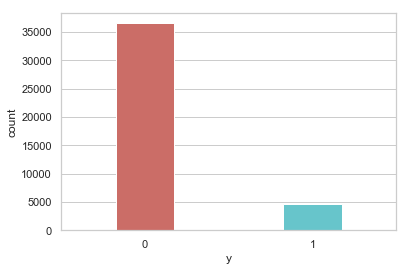

In [7]:
# Count Plot
fig,ax = plt.subplots()
sns.countplot(x = 'y', ax = ax, data = data, palette = 'hls')
# this function changes thw width of the patches (bars)
# https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax, .35)
plt.show()

In [8]:
count_no_sub = len(data[data['y'] == 0])
count_sub = len(data[data['y'] == 1])
print("Percentage of no subscription: ",(count_no_sub/(count_no_sub + count_sub))*100)
print("Percentage of no subscription: ",(count_sub/(count_no_sub + count_sub))*100)

Percentage of no subscription:  88.73458288821988
Percentage of no subscription:  11.265417111780131


In [9]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [10]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


### 1. Plotting Subscription purchase frequency by job

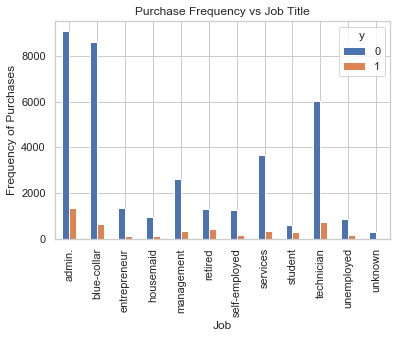

In [11]:
pd.crosstab(data.job, data.y).plot(kind = 'bar')
plt.title('Purchase Frequency vs Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchases')
plt.show()

#### <b>Frequency of Purchase looks to be highly dependent on the job title</b>

### 2. Plotting subscription purchase frequency by education

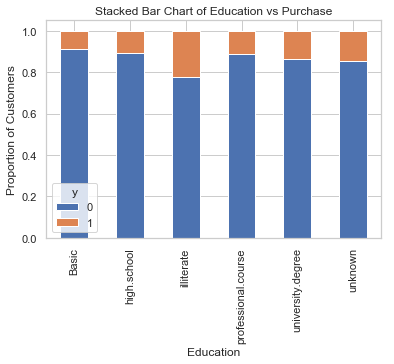

In [12]:
table = pd.crosstab(data.education, data.y)
row_totals = table.sum(1).astype(float) # totals of both subscriptions and no subcriptions
table.div(row_totals, axis = 0).plot(kind = "bar", stacked = True) # Proportions of both scriptions and no subscriptions'
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.show()

#### <b>Education seems to be a decent predictor</b>

### 3. Purchase frequency by month

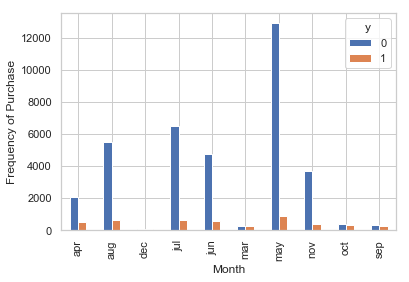

In [13]:
pd.crosstab(data.month, data.y).plot(kind = "bar")
plt.xlabel("Month")
plt.ylabel('Frequency of Purchase')
plt.show()

#### <b>Month also looks like a good predictor</b>

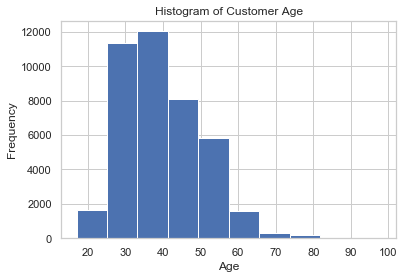

In [14]:
data.age.hist()
plt.title('Histogram of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### 4. Purchase Frequency by previous campaign outcome (poutcome)

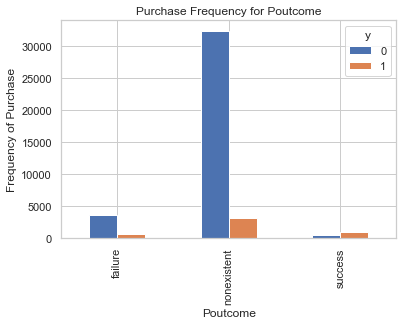

In [15]:
pd.crosstab(data.poutcome, data.y).plot(kind = 'bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.show()

#### <b>Poutcome seems to be a good predictor</b>

### <b>Creating dummy variables</b>

In [16]:
cat_vars = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list = pd.get_dummies(data[var], prefix = var)
    data1 = data.join(cat_list)
    data = data1

In [17]:
# removing the old categorical variables and retaining the rest (including the newly created dummy variables)
data_vars = data.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]
data_final = data[to_keep]
print(data_final.columns.values)

['age' 'duration' 'campaign' 'pdays' 'previous' 'emp_var_rate'
 'cons_price_idx' 'cons_conf_idx' 'euribor3m' 'nr_employed' 'y'
 'job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'marital_unknown'
 'education_Basic' 'education_high.school' 'education_illiterate'
 'education_professional.course' 'education_university.degree'
 'education_unknown' 'default_no' 'default_unknown' 'default_yes'
 'housing_no' 'housing_unknown' 'housing_yes' 'loan_no' 'loan_unknown'
 'loan_yes' 'contact_cellular' 'contact_telephone' 'month_apr' 'month_aug'
 'month_dec' 'month_jul' 'month_jun' 'month_mar' 'month_may' 'month_nov'
 'month_oct' 'month_sep' 'day_of_week_fri' 'day_of_week_mon'
 'day_of_week_thu' 'day_of_week_tue' 'day_of_week_wed' 'poutcome_failure'
 'poutcome_nonexistent' 'poutcome_success']


## <center><b>Over-sampling using SMOTE</b></center>
1. Works by creating synthetic samples from the minor (under-represented) class
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked new observations

In [18]:
X = data_final.loc[:,data_final.columns != 'y'] # all features
y = data_final.loc[:,data_final.columns == 'y'] # labels

In [19]:
# initializing SMOTE
os = SMOTE(random_state = 42)

In [20]:
# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
columns = X_train.columns

In [21]:
# SMOTE analysis
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
os_data_y = pd.DataFrame(data = os_data_y, columns = ['y'])

/Users/ghai7c/anaconda3/envs/ML_practise/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print("Length of oversampled data is: ",len(os_data_X))
print("Number of no subscriptions in oversampled data: ",len(os_data_y[os_data_y['y'] == 0]))
print("Number of suscriptions: ",len(os_data_y[os_data_y['y'] == 1]))
print("Proportion of no suscription data in oversampled data is: ",len(os_data_y[os_data_y['y'] == 0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is: ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Length of oversampled data is:  51234
Number of no subscriptions in oversampled data:  25617
Number of suscriptions:  25617
Proportion of no suscription data in oversampled data is:  0.5
Proportion of subscription data in oversampled data is:  0.5


## <center><b> Recursive Feature elimination (RFE) </b></center>

In [25]:
data_final_vars = data_final.columns.tolist()
y = ['y']
X = [ var for var in data_final_vars if var not in y]

In [27]:
#initializing logistic regression model
model = LogisticRegression()

In [34]:
# Initializing RFE model. 20 = final count of features requested
rfe = RFE(model, n_features_to_select = 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_) # ranking of features in order

[False False False False  True False False False  True False False False
 False False False False False False  True False False False False False
 False False False False False False False False  True  True False False
 False False False False False  True  True  True  True  True  True  True
  True  True  True False  True False  True False False False  True  True
  True]
[38 36 22 42  1  9 15 32  1 31 21 34 16 29 23  8 33 24  1 20 41 26 25 37
 18  7  2  3 19  4  6  5  1  1 40 10 12 11 13 39 14  1  1  1  1  1  1  1
  1  1  1 28  1 30  1 27 35 17  1  1  1]


In [42]:
# final set of features
selected_cols = np.array(X)[rfe.support_]
X = os_data_X[selected_cols]
y = os_data_y['y']

## <center><b>Implementing the model</b></center>

In [44]:
# splitting the dataset into training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [45]:
# fitting the logistic regression model -> default parameters
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
# predictions and accuracy calculation on test set
y_pred = model.predict(X_test)
print("Accuracy of logistic regression classifier on test set:{:.2f}".format(model.score(X_test,y_test)))

Accuracy of logistic regression classifier on test set:0.74


In [49]:
# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6145 1550]
 [2468 5208]]


## <center><b> Computer precision, recall, F-measure</b></center>
<b>precision: </b>Fraction of actual true positives among all predictive positive classes. Can also be interpreted as probability that a randomly selected observation is actually positive. <br>
<b>Recall: </b>Fraction of true positives that have been retrieved by the classifier. Can also be interpreted as probability that a positive observation is retrieved in a search.<br>
<b>F-measure: </b>Harmonic mean of precision and recall.

In [51]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.71      0.80      0.75      7695
          1       0.77      0.68      0.72      7676

avg / total       0.74      0.74      0.74     15371



In [53]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(logit_roc_auc)

0.7385244372390455


In [55]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

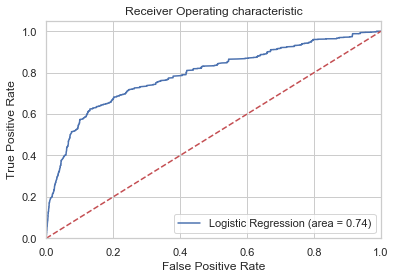

In [58]:
plt.figure()
plt.plot(fpr,tpr,label = 'Logistic Regression (area = %0.2f)' %logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating characteristic')
plt.legend(loc = 'lower right')
plt.show()